In [1]:
import warnings
warnings.filterwarnings("ignore")

# 1º: Create the Molecule and Hamiltonian

In the code cells below, we create the molecular geometry of H2 with the radial distance of 1,401 a.u. with the optimal internuclear distance of Kolos and Wolniewicz. We will use the STO-3G minimal basis set by importing the parameters of the basis set exchange functions. Pennylane allows us to construct the Hamiltonian from the second quantization with the Jordan-Wigner transformation.

In [2]:
from qiskit_ibm_runtime.fake_provider import FakeAthensV2
from pennylane_qiskit import qiskit_session
from skquant.opt import minimize

from pennylane import numpy as np
import matplotlib.pyplot as plt
import pennylane as qml
import torch

symbols = ["H", "H"]
coordinates = np.array([[0.0, 0.0, 0], [0.0, 0.0, 1.401]], requires_grad = False)
molecule = qml.qchem.Molecule(symbols, coordinates, basis_name='STO-3G', load_data=True, unit='bohr')
H, qubits = qml.qchem.molecular_hamiltonian(molecule)

print("Number of qubits = ", qubits)
print("The Hamiltonian is ", H)

Number of qubits =  4
The Hamiltonian is  -0.09883485860187924 * I([0, 1, 2, 3]) + 0.17120123803197834 * Z(0) + 0.17120123803197845 * Z(1) + 0.16862327620358059 * (Z(0) @ Z(1)) + -0.22279639115527738 * Z(2) + 0.12054612718324412 * (Z(0) @ Z(2)) + 0.16586801098505832 * (Z(1) @ Z(2)) + 0.045321883801814206 * (Y(0) @ X(1) @ X(2) @ Y(3)) + -0.045321883801814206 * (Y(0) @ Y(1) @ X(2) @ X(3)) + -0.045321883801814206 * (X(0) @ X(1) @ Y(2) @ Y(3)) + 0.045321883801814206 * (X(0) @ Y(1) @ Y(2) @ X(3)) + -0.22279639115527738 * Z(3) + 0.16586801098505832 * (Z(0) @ Z(3)) + 0.12054612718324412 * (Z(1) @ Z(3)) + 0.17434948668373768 * (Z(2) @ Z(3))


# 2º: Configure the Simulator

In the cells below, we set up a noisy 5-qubit simulator called FakeAthensV2 with the pennylane-qiskit plugin. Our purpose is to simulate UCCSD with the ground state and doubly excited state via Givens rotations, provided by Pennylane. The purpose of the circuit is to compute the expectation value of the Hamiltonian.

In [3]:
try:
    fake_athensv2 = FakeAthensV2()
    num_qubits = fake_athensv2.num_qubits
    dev = qml.device("qiskit.remote", wires=num_qubits, backend=fake_athensv2,shots=8000)
except Exception as exc:
    print("failed to connect to backend. Exception thrown")
    print(exc)

In [4]:
electrons = 2
hf = qml.qchem.hf_state(electrons, qubits)
print(hf)

[1 1 0 0]


In [5]:
@qml.qnode(dev)
def circuit(param, wires):
    qml.BasisState(hf, wires=wires)
    qml.DoubleExcitation(param, wires=[0, 1, 2, 3])
    return qml.expval(H)

In [6]:
def cost_fn(param):
    return float(circuit(param, wires=range(qubits)))

# 3º: Configure the optimizer and run the circuit

In the code cells below, we configure the ImFil optimizer, a derivative-free optimizer that is great for noisy environments. It is important to note that although the optimizer is designed to work well in noisy environments, this does not make it noise-proof and fully capable of finding the solution in noisy environments.

We configure it with 500 steps (converging in less than 40 steps), starting from parameter 0 and exploring the limited region from -1.0 to 1.0. We also pass the parameter angles that will be optimized. We run the circuit until it reaches convergence (minimum).

In [12]:
theta0 = np.array([0.0])
budget = 500
bounds = np.array([[-1.0, 1.0]], dtype=float)

In [13]:
result, history = minimize(cost_fn, theta0, bounds, budget, method='imfil')

In [14]:
print(f"Optimal Energy Found: {result.optval} ha")
print(f"Optimal Parameter Found: {result.optpar} rad")

Optimal Energy Found: -0.5067715220363072 ha
Optimal Parameter Found: 0.03125 rad


# 4º: Collect and Analyze Results

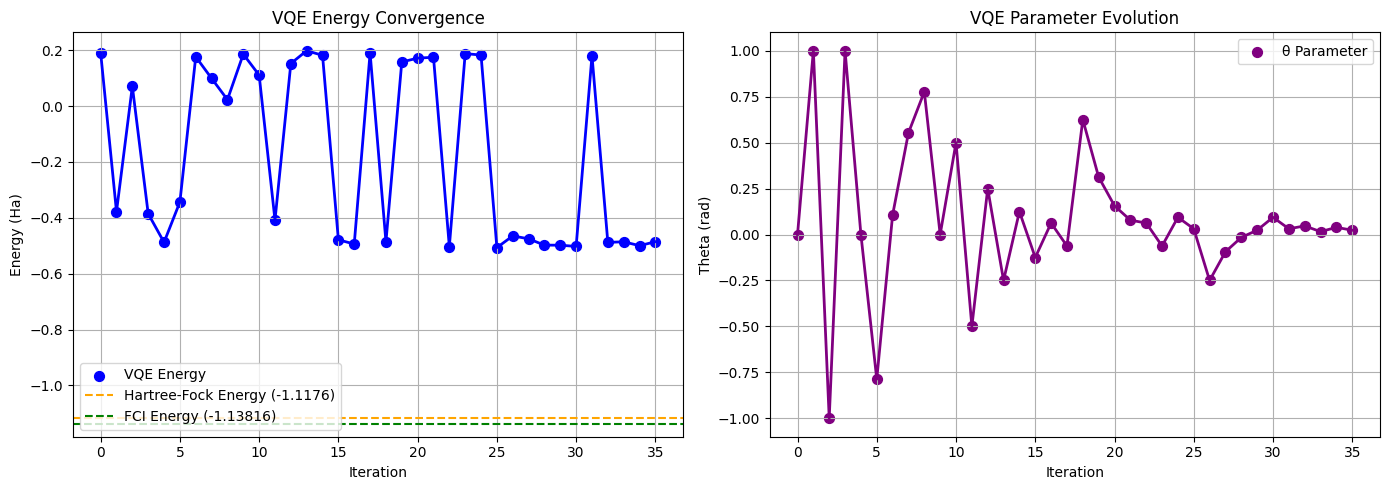

In [15]:
hf_energy = -1.1176
fci_energy = -1.13816

energies = [e[0] for e in history]
thetas = [t[1] for t in history]
steps = list(range(len(energies)))

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

axs[0].scatter(steps, energies, label='VQE Energy', color='blue', s=50)
axs[0].plot(steps, energies, color='blue', linewidth=2)
axs[0].axhline(hf_energy, color='orange', linestyle='--', label=f'Hartree-Fock Energy ({hf_energy})')
axs[0].axhline(fci_energy, color='green', linestyle='--', label=f'FCI Energy ({fci_energy})')
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Energy (Ha)')
axs[0].set_title('VQE Energy Convergence')
axs[0].legend()
axs[0].grid(True)

axs[1].scatter(steps, thetas, label='θ Parameter', color='purple', s=50)
axs[1].plot(steps, thetas, color='purple', linewidth=2)
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('Theta (rad)')
axs[1].set_title('VQE Parameter Evolution')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()
